# 基于卷积神经网络的表情分类

完成人：第六组

## 基本情况

我们借鉴较为成熟的卷积神经网络，自己调整输入和输出，完成了本次作业。主要分为以下步骤：

![表情分类](./src/表情分类.png)

## 1. 输入数据的转换

首先我们查看一下输入的图片。

In [1]:
%%html
<img src="./data/train/anger_05_110_2542.jpg", width=320, heigth=240>

我们可以看到图片是彩色的，且图片中人脸只占据了很小的部分。下面我们用OpenCV提供的工具对图片进行处理，选择出其中的人脸部分，并将图片转换成黑白。

首先导入需要的包和OpenCV人脸检测模块，并设定我们想要将图片处理成的大小，即$48*48$的一个numpy的array。

In [2]:
import cv2
import numpy as np
import os
from PIL import Image
from torchvision import transforms

faceCascade = cv2.CascadeClassifier('./src/visualize/haarcascade_frontalface_default.xml')
shape = (48,48)

因为神经网络需要格式化的输入，我们对图片预处理，将每个图片转换成$48*48$的数组。

In [3]:
def preprocess(image_path):
    transform_test = transforms.Compose([
        transforms.ToTensor()
    ])
    image = cv2.imread(image_path)
    faces = faceCascade.detectMultiScale(
        image,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(1, 1),
        flags=cv2.CASCADE_SCALE_IMAGE
    )

    if len(faces) == 0:
        print('no face found')
        face = cv2.resize(image, shape)
    else:
        (x, y, w, h) = faces[0]
        face = image[y:y + h, x:x + w]
        face = cv2.resize(face, shape)

    img = Image.fromarray(face).convert('L')
    inputs = np.asarray(img)
    return inputs, face

对文件夹中所有的图片进行处理，得到一个csv文件存放所有的输入数据。

整个过程大致需要三分钟。

In [4]:
def img2csv():
    if os.path.exists('./input_csv/train_test.csv'):
        return
    path_train = './data/train/'
    path_test = './data/test/'
    with open('./input_csv/train_test.csv', 'w') as f:
        f.write("emotion,pixels,Usage\n")
        for filename in os.listdir(path_train):
            target, raw_image = preprocess(path_train + str(filename))
            emotion = filename.split('_',-1)[0]
            if emotion == 'anger':
                emotion = 0
            elif emotion == 'disgust':
                emotion = 1
            elif emotion == 'fear':
                emotion = 2
            elif emotion == 'happy':
                emotion = 3
            elif emotion == 'sad':
                emotion = 4
            elif emotion == 'surprise':
                emotion = 5
            elif emotion == 'neutral':
                emotion = 6
            pixels = target
            usage = 'Training'

            f.write(str(emotion) + ',')
            for hang in pixels:
                for ele in hang:
                    f.write(str(ele) + ' ')
            f.write(',' + usage + '\n')

        i = 0
        for filename in os.listdir(path_test):
            target, raw_image = preprocess(path_test + str(filename))
            emotion = filename.split('_',-1)[0]
            if emotion == 'anger':
                emotion = 0
            elif emotion == 'disgust':
                emotion = 1
            elif emotion == 'fear':
                emotion = 2
            elif emotion == 'happy':
                emotion = 3
            elif emotion == 'sad':
                emotion = 4
            elif emotion == 'surprise':
                emotion = 5
            elif emotion == 'neutral':
                emotion = 6
            pixels = target

            
            if i == 0:
                usage = 'PrivateTest'
                i = i + 1
            else:
                usage = 'PublicTest'
                i = i - 1

            f.write(str(emotion) + ',')
            for hang in pixels:
                for ele in hang:
                    f.write(str(ele) + ' ')
            f.write(',' + usage + '\n')
img2csv()

现在我们查看一下转换成的csv文件，这也就是我们神经网络的输入。

In [5]:
import pandas as pd
csv = pd.read_csv('./input_csv/train_test.csv')
csv

,emotion,pixels,Usage
0,0,146 125 66 55 57 76 68 65 89 85 86 75 69 65 74...,Training
1,0,175 161 67 52 38 43 59 76 87 106 110 121 129 1...,Training
2,0,179 179 177 146 64 52 69 54 34 27 45 54 58 52 ...,Training
3,0,179 180 163 138 44 38 53 49 36 37 43 74 94 100...,Training
4,0,19 20 16 22 27 61 81 77 91 108 115 123 128 137...,Training
...,...,...,...
1601,5,220 220 219 220 70 40 28 39 63 61 73 90 59 37 ...,PublicTest
1602,5,209 205 194 154 45 30 43 29 36 38 52 61 53 42 ...,PrivateTest
1603,5,182 180 181 181 180 181 177 177 124 46 33 32 5...,PublicTest
1604,5,216 218 217 42 42 37 35 59 34 27 69 74 83 84 7...,PrivateTest


## 2. 卷积神经网络的定义

In [6]:
import torch.nn as nn
class SeparableConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, dilation, groups=in_channels,
                                   bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, 1, 0, 1, 1, bias=bias)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

In [7]:
class ResidualBlock(nn.Module):

    def __init__(self, in_channeld, out_channels):
        super(ResidualBlock, self).__init__()

        self.residual_conv = nn.Conv2d(in_channels=in_channeld, out_channels=out_channels, kernel_size=1, stride=2,
                                       bias=False)
        self.residual_bn = nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)

        self.sepConv1 = SeparableConv2d(in_channels=in_channeld, out_channels=out_channels, kernel_size=3, bias=False,
                                        padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)
        self.relu = nn.ReLU()

        self.sepConv2 = SeparableConv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, bias=False,
                                        padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)
        self.maxp = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        res = self.residual_conv(x)
        res = self.residual_bn(res)
        x = self.sepConv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.sepConv2(x)
        x = self.bn2(x)
        x = self.maxp(x)
        return res + x

In [8]:
class Model(nn.Module):

    def __init__(self, num_classes):
        super(Model, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(8, affine=True, momentum=0.99, eps=1e-3)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, bias=False)
        self.bn2 = nn.BatchNorm2d(8, momentum=0.99, eps=1e-3)
        self.relu2 = nn.ReLU()

        self.module1 = ResidualBlock(in_channeld=8, out_channels=16)
        self.module2 = ResidualBlock(in_channeld=16, out_channels=32)
        self.module3 = ResidualBlock(in_channeld=32, out_channels=64)
        self.module4 = ResidualBlock(in_channeld=64, out_channels=128)

        self.last_conv = nn.Conv2d(in_channels=128, out_channels=num_classes, kernel_size=3, padding=1)
        self.avgp = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, input):
        x = input
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.module1(x)
        x = self.module2(x)
        x = self.module3(x)
        x = self.module4(x)
        x = self.last_conv(x)
        x = self.avgp(x)
        x = x.view((x.shape[0], -1))
        return x

## 3. 神经网络的初始化

In [9]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import csv
from PIL import Image
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

if not torch.cuda.is_available():
    from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

shape = (48, 48)

In [10]:
class DataSetFactory:

    def __init__(self):
        images = []
        emotions = []
        private_images = []
        private_emotions = []
        public_images = []
        public_emotions = []

        with open('./input_csv/train_test.csv', 'r') as csvin:
            data = csv.reader(csvin)
            next(data)
            for row in data:
                face = [int(pixel) for pixel in row[1].split()]
                face = np.asarray(face).reshape(48, 48)
                face = face.astype('uint8')

                if row[-1] == 'Training':
                    emotions.append(int(row[0]))
                    images.append(Image.fromarray(face))
                elif row[-1] == "PrivateTest":
                    private_emotions.append(int(row[0]))
                    private_images.append(Image.fromarray(face))
                elif row[-1] == "PublicTest":
                    public_emotions.append(int(row[0]))
                    public_images.append(Image.fromarray(face))

        print('training size %d : private val size %d : public val size %d' % (
            len(images), len(private_images), len(public_images)))
        train_transform = transforms.Compose([
            transforms.RandomCrop(shape[0]),
            transforms.RandomHorizontalFlip(),
            ToTensor(),
        ])
        val_transform = transforms.Compose([
            transforms.CenterCrop(shape[0]),
            ToTensor(),
        ])

        self.training = DataSet(transform=train_transform, images=images, emotions=emotions)
        self.private = DataSet(transform=val_transform, images=private_images, emotions=private_emotions)
        self.public = DataSet(transform=val_transform, images=public_images, emotions=public_emotions)

In [11]:
class DataSet(torch.utils.data.Dataset):

    def __init__(self, transform=None, images=None, emotions=None):
        self.transform = transform
        self.images = images
        self.emotions = emotions

    def __getitem__(self, index):
        image = self.images[index]
        emotion = self.emotions[index]
        if self.transform is not None:
            image = self.transform(image)
        return image, emotion

    def __len__(self):
        return len(self.images)

In [12]:
# variables  -------------
batch_size = 128
lr = 0.01
epochs = 300
learning_rate_decay_start = 80
learning_rate_decay_every = 5
learning_rate_decay_rate = 0.9
# ------------------------

In [13]:
classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
network = Model(num_classes=len(classes)).to(device)
if not torch.cuda.is_available():
    summary(network, (1, shape[0], shape[1]))

optimizer = torch.optim.SGD(network.parameters(), lr=lr, momentum=0.9, weight_decay=5e-3)
criterion = nn.CrossEntropyLoss()
factory = DataSetFactory()

training_loader = DataLoader(factory.training, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loader = {
    'private': DataLoader(factory.private, batch_size=batch_size, shuffle=True, num_workers=0),
    'public': DataLoader(factory.public, batch_size=batch_size, shuffle=True, num_workers=0)
}

min_validation_loss = {
    'private': 10000,
    'public': 10000,
}

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 46, 46]              72
       BatchNorm2d-2            [-1, 8, 46, 46]              16
              ReLU-3            [-1, 8, 46, 46]               0
            Conv2d-4            [-1, 8, 44, 44]             576
       BatchNorm2d-5            [-1, 8, 44, 44]              16
              ReLU-6            [-1, 8, 44, 44]               0
            Conv2d-7           [-1, 16, 22, 22]             128
       BatchNorm2d-8           [-1, 16, 22, 22]              32
            Conv2d-9            [-1, 8, 44, 44]              72
           Conv2d-10           [-1, 16, 44, 44]             128
  SeparableConv2d-11           [-1, 16, 44, 44]               0
      BatchNorm2d-12           [-1, 16, 44, 44]              32
             ReLU-13           [-1, 16, 44, 44]               0
           Conv2d-14           [-1, 16,

## 4. 神经网络的训练

In [14]:
for epoch in range(epochs):
    network.train()
    total = 0
    correct = 0
    total_train_loss = 0
    if epoch > learning_rate_decay_start and learning_rate_decay_start >= 0:

        #
        frac = (epoch - learning_rate_decay_start) // learning_rate_decay_every
        decay_factor = learning_rate_decay_rate ** frac
        current_lr = lr * decay_factor
        for group in optimizer.param_groups:
            group['lr'] = current_lr
    else:
        current_lr = lr

    print('learning_rate: %s' % str(current_lr))
    for i, (x_train, y_train) in enumerate(training_loader):
        optimizer.zero_grad()
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        y_predicted = network(x_train)
        loss = criterion(y_predicted, y_train)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(y_predicted.data, 1)
        total_train_loss += loss.data
        total += y_train.size(0)
        correct += predicted.eq(y_train.data).sum()
    accuracy = 100. * float(correct) / total
    print('Epoch [%d/%d] Training Loss: %.4f, Accuracy: %.4f' % (
        epoch + 1, epochs, total_train_loss / (i + 1), accuracy))

    network.eval()
    with torch.no_grad():
        for name in ['private', 'public']:
            total = 0
            correct = 0
            total_validation_loss = 0
            for j, (x_val, y_val) in enumerate(validation_loader[name]):
                x_val = x_val.to(device)
                y_val = y_val.to(device)
                y_val_predicted = network(x_val)
                val_loss = criterion(y_val_predicted, y_val)
                _, predicted = torch.max(y_val_predicted.data, 1)
                total_validation_loss += val_loss.data
                total += y_val.size(0)
                correct += predicted.eq(y_val.data).sum()

            accuracy = 100. * float(correct) / total
            if total_validation_loss <= min_validation_loss[name] or epoch==epochs-1:
                if epoch >= 10:
                    print('saving new model')
                    state = {'net': network.state_dict()}
                    torch.save(state, './weights/%s_model_%d_%d.t7' % (name, epoch + 1, accuracy))
                min_validation_loss[name] = total_validation_loss

            print('Epoch [%d/%d] %s validation Loss: %.4f, Accuracy: %.4f' % (
                epoch + 1, epochs, name, total_validation_loss / (j + 1), accuracy))

learning_rate: 0.01
Epoch [1/300] Training Loss: 1.9694, Accuracy: 20.3271
Epoch [1/300] private validation Loss: 2.6833, Accuracy: 16.1491
Epoch [1/300] public validation Loss: 2.5086, Accuracy: 16.7702
learning_rate: 0.01


KeyboardInterrupt: 

## 5. 对测试数据的处理

In [15]:
import os.path as osp

import cv2
import matplotlib.cm as cm
import numpy as np
import torch.hub
import os
from PIL import Image
from torchvision import transforms
from torchsummary import summary
from src.visualize.grad_cam import BackPropagation, GradCAM,GuidedBackPropagation

faceCascade = cv2.CascadeClassifier('./src/visualize/haarcascade_frontalface_default.xml')
shape = (44,44)
classes = [
    'anger',
    'disgust',
    'fear',
    'happy',
    'sad',
    'surprise',
    'neutral'
]

In [16]:
def preprocess2(image_path):
    transform_test = transforms.Compose([
        transforms.ToTensor()
    ])
    image = cv2.imread(image_path)
    faces = faceCascade.detectMultiScale(
        image,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(1, 1),
        flags=cv2.CASCADE_SCALE_IMAGE
    )

    if len(faces) == 0:
        print('no face found')
        face = cv2.resize(image, shape)
    else:
        (x, y, w, h) = faces[0]
        face = image[y:y + h, x:x + w]
        face = cv2.resize(face, shape)

    img = Image.fromarray(face).convert('L')
    inputs = transform_test(img)
    return inputs, face


def get_gradient_image(gradient):
    gradient = gradient.cpu().numpy().transpose(1, 2, 0)
    gradient -= gradient.min()
    gradient /= gradient.max()
    gradient *= 255.0
    return np.uint8(gradient)


def get_gradcam_image(gcam, raw_image, paper_cmap=False):
    gcam = gcam.cpu().numpy()
    cmap = cm.jet_r(gcam)[..., :3] * 255.0
    if paper_cmap:
        alpha = gcam[..., None]
        gcam = alpha * cmap + (1 - alpha) * raw_image
    else:
        gcam = (cmap.astype(np.float) + raw_image.astype(np.float)) / 2
    return np.uint8(gcam)

## 6. 可视化输出的设置

In [17]:
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
now = time.strftime('%Y-%m-%d_%H-%M-%S',time.localtime(time.time()))

def guided_backprop(images, model_name):

    for i, image in enumerate(images):
        target, raw_image = preprocess2(image['path'])
        image['image'] = target
        image['raw_image'] = raw_image

    net = Model(num_classes=len(classes))
    checkpoint = torch.load(os.path.join('./weights', model_name), map_location=torch.device('cpu'))
    net.load_state_dict(checkpoint['net'])
    net.eval()
#     summary(net, (1, shape[0], shape[1]))

    result_images = []
    for index, image in enumerate(images):
        img = torch.stack([image['image']])
        bp = BackPropagation(model=net)
        probs, ids = bp.forward(img)
        gcam = GradCAM(model=net)
        _ = gcam.forward(img)

        gbp = GuidedBackPropagation(model=net)
        _ = gbp.forward(img)

        # Guided Backpropagation
        actual_emotion = ids[:,0]
        gbp.backward(ids=actual_emotion.reshape(1,1))
        gradients = gbp.generate()

        # Grad-CAM
        gcam.backward(ids=actual_emotion.reshape(1,1))
        regions = gcam.generate(target_layer='last_conv')

        # Get Images
        label_image = np.zeros((shape[0],65, 3), np.uint8)
        cv2.putText(label_image, classes[actual_emotion.data], (5, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, cv2.LINE_AA)

        prob_image = np.zeros((shape[0],60,3), np.uint8)
        cv2.putText(prob_image, '%.1f%%' % (probs.data[:,0] * 100), (5, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

        guided_bpg_image = get_gradient_image(gradients[0])
        guided_bpg_image = cv2.merge((guided_bpg_image, guided_bpg_image, guided_bpg_image))

        grad_cam_image = get_gradcam_image(gcam=regions[0, 0],raw_image=image['raw_image'])

        guided_gradcam_image = get_gradient_image(torch.mul(regions, gradients)[0])
        guided_gradcam_image = cv2.merge((guided_gradcam_image, guided_gradcam_image, guided_gradcam_image))

        img = cv2.hconcat([image['raw_image'],label_image,prob_image,guided_bpg_image,grad_cam_image,guided_gradcam_image])
        result_images.append(img)
        print(image['path'],classes[actual_emotion.data], probs.data[:,0] * 100)
    cv2.imwrite('./result/result_'+now+'.jpg',cv2.resize(cv2.vconcat(result_images), None, fx=2,fy=2))
    lena = mpimg.imread('./result/result_'+now+'.jpg')
    plt.figure(figsize=(15,15))
    plt.imshow(lena)

## 7.测试神经网络

将要测试的文件放在test文件夹里即可。

./test/1.jpg happy tensor([97.8508])
./test/2.jpeg disgust tensor([99.7764])
./test/5.jpg disgust tensor([85.4958])
./test/fear_08_349_4562.jpg fear tensor([78.5833])
./test/sad_03_393_3464.jpg sad tensor([94.6286])
./test/y.jpg neutral tensor([76.7662])


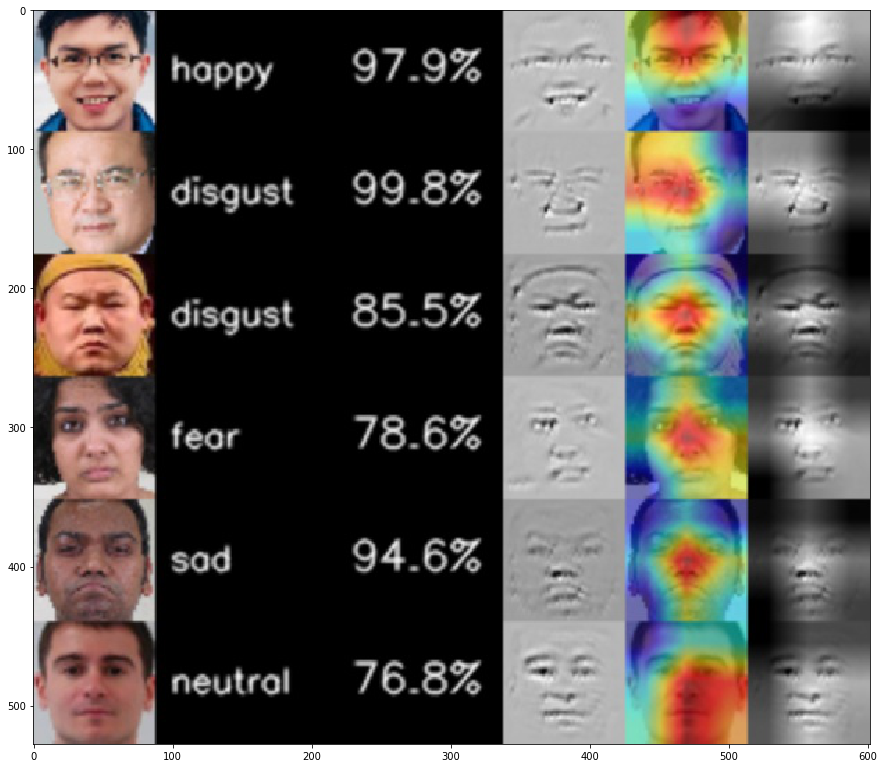

In [22]:
import os

test_path = './test/'
images = []
for filename in os.listdir(test_path):
    images.append({'path':test_path+filename})
    
guided_backprop(
    images=images,
    model_name='private_model_133_77.t7'
)